## Assignment 1

Two datasets are given  
1. `HovsoreData_Sonic_100m_2004-2013.csv`  
contains about 10 years of simultaneous wind
speed and turbulence measurements.  

2. `ML_ExampleDataSet.xlsx`  
contains data of simulated 10-minute realizations of damageequivalent loads (DEL) for the DTU 10MW reference wind turbine as function of various external
conditions, including wind speed, turbulence, wind shear.

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
import seaborn as sns
from scipy.special import erf, erfinv
import scipy

In [130]:
# Helper function - Normal distribution
def NormalDist(task, x, mu=0, sigma=1):
    """Normal distribution function

    Parameters
    ----------
    task : int
        0: PDF, 1: Cumulative, 2: Inverse
    x : np.array
        Data
    mu : float, optional
        Mean, by default 0
    sigma : float, optional
        Standard deviation, by default 1
    Returns
    -------
    np.array
        Normal distribution y values for the given task
    """
    
    if task == 0:  # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi))) * \
            np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
            
    elif task == 1:  # Cumulative
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
        
    elif task == 2:  # Inverse
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)
    
    return y

# Helper function - lognormal distribution
def LogNormDist(task, x, mu, sigma):
    """Lognormal distribution function

    Parameters
    ----------
    task : int
        0: PDF, 1: Cumulative, 2: Inverse
    x : np.array
        Data
    mu : float
        Mean
    sigma : float
        Standard deviation

    Returns
    -------
    np.array
        Lognormal distribution y values for the given task
    """
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu < tol] = tol
    Eps = np.sqrt(np.log(1.0+(sigma/mu)**2))
    Ksi = np.log(mu)-0.5*Eps**2
    
    if task == 0:  # PDF
        x[x <= 0] = 1e-8
        u = (np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
        
    elif task == 1:  # Cummulative
        x[x <= 0] = 1e-8
        u = (np.log(x)-Ksi)/Eps
        y = NormalDist(1, u)
        
    elif task == 2:  # Inverse
        y = np.exp(Ksi+Eps*NormalDist(2, x))

    return y

### Loading the first dataset
Note that there are some extreme wind speeds in the dataset, which are likely to be errors so they are removed using the `lim_df` function.

Notes about data cleaning:
- The data is cleaned by removing rows with extreme wind speeds currently set to 50 m/s. Would be nice...

I have wind speed data for 10 years, 2004-2013. I will use bootstrapping to find a distribution of the yearly mean wind speed for the given site. This turns out to be a normal distribution and i consider this the uncertainty in the mean wind speed of the site. I divide the data by the mean wind speed so i get at normal distribution with mean 1. When i sample new wind data from a weibull distribution i multiply weibull_A with the uncertainty in the mean wind speed that i just described. I want to further incorporate a 2% uncertainty for the wind speed measurements. I do this by

In [132]:
data1 = pd.read_csv('../Datasets/HovsoreData_Sonic_100m_2004-2013.csv')

def lim_df(df, column, lower=None, upper=None):
    """
    Limit a DataFrame based on a column's values.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to be limited.
    column : str
        Column to be limited.
    lower : float, optional
        Lower limit for the column. Default is None.
    upper : float, optional
        Upper limit for the column. Default is None.

    Returns
    -------
    pd.DataFrame
        Limited DataFrame.
    """
    if lower is not None:
        df = df[df[column] >= lower]
    if upper is not None:
        df = df[df[column] <= upper]
    return df

wsp_min = 0.6  # Limit for wind speed

# The highes wind speed recorded in Denmark is 53.6 m/s
# Source: https://www.dmi.dk/nyheder/2014/et-ar-siden-usadvanlige-normale-allan-1
wsp_max = 53.6  # Limit for wind speed

TI_min = 0.001  # Limit for turbulence intensity
TI_max = 0.4  # Limit for turbulence intensity

pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)


cols = ['Timestamp', 'Wsp', 'TI']

# Chain operations
data1 = (
    data1
    [cols]  # Select columns
    # Filter out rows where Wsp is greater than wsp_lim
    .pipe(lim_df, 'Wsp', lower=wsp_min, upper=wsp_max)
    .pipe(lim_df, 'TI', lower=TI_min, upper=TI_max)
    # Create a std column based on the Wsp and TI columns
    .assign(SigmaU=lambda x: x['Wsp'] * x['TI'])
    # Set timestamp based on the Timestamp-column with the format 'YYYYMMDDHHMM'
    .assign(Timestamp=pd.to_datetime(data1['Timestamp'], format=r'%Y%m%d%H%M'))
    # Set the Timestamp-column as the index
    .set_index('Timestamp')
)
data1

,Wsp,TI,SigmaU
Timestamp,,,
2004-10-01 00:00:00,9.9196,0.0181,0.179545
2004-10-01 00:20:00,9.5073,0.0145,0.137856
2004-10-01 00:30:00,9.5274,0.0210,0.200075
2004-10-01 00:40:00,9.9498,0.0253,0.251730
2004-10-01 00:50:00,10.2376,0.0151,0.154588
...,...,...,...
2013-08-31 23:10:00,15.6264,0.0773,1.207921
2013-08-31 23:20:00,13.7150,0.0576,0.789984
2013-08-31 23:30:00,13.4969,0.0797,1.075703


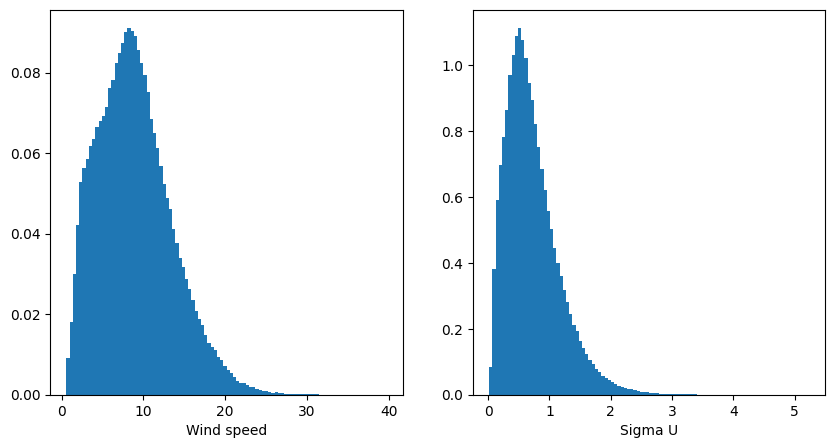

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axs
ax1.hist(data1['Wsp'], bins=100, density=True)
ax2.hist(data1['SigmaU'], bins=100, density=True)
ax1.set_xlabel('Wind speed')
ax2.set_xlabel('Sigma U')
plt.show()

In [134]:
# sns.pairplot(data1, kind='hist', diag_kws={'bins': 25}) 

c:\Users\Toke Schäffer\Documents\Egne mapper\DTU\Kandidat\3. semester vind\46500 Probabilistic Methods in Wind Energy\.venv\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\Toke Schäffer\Documents\Egne mapper\DTU\Kandidat\3. semester vind\46500 Probabilistic Methods in Wind Energy\.venv\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


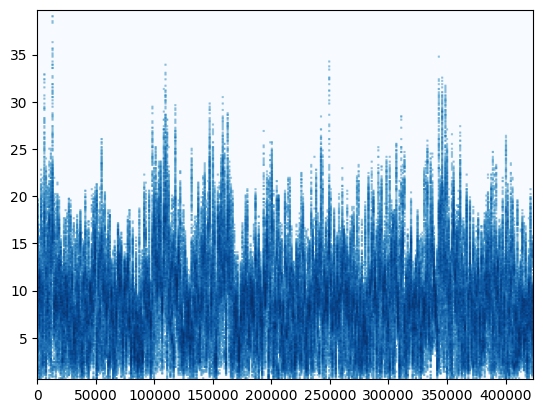

In [135]:
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import mpl_scatter_density

norm = ImageNormalize(vmin=0., vmax=50, stretch=LogStretch())

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

ax.scatter_density(np.arange(len(data1)), data1['Wsp'], norm=norm, cmap='Blues')

plt.show()

In [136]:
# WIND SPEED DISTRIBUTION FIT
Wsp0 = np.asarray(data1['Wsp']) # Wind speed data
WeibLikelihoodFunc = lambda x: -np.sum(np.log(stats.weibull_min.pdf(Wsp0, x[0], loc=0, scale=x[1])))
# WeibLikelihoodFunc = lambda x: -np.sum(np.log(stats.weibull_min.pdf(Wsp0, x[0], 0, x[1])))
Weib0 = scipy.optimize.minimize(WeibLikelihoodFunc, [1, 1])
WeibullA = Weib0.x[0]
Weibullk = Weib0.x[1]
print('Weibull A:', WeibullA, 'k:', Weibullk)

Weibull A: 2.0751296682968032 k: 10.089123144121405


In [137]:
# CONDITION DISTRIBUTION OF TURBULENCE - BASED ON DATA BINNING
WspBinEdges = np.arange(3.5, 33.5, 1)
WspBinCenters = WspBinEdges[:-1] + 0.5

MuSigmaBinned = np.zeros(len(WspBinCenters))
SigmaSigmaBinned = np.zeros(len(WspBinCenters))

nData = len(data1['Wsp'])

# Per wind speed
for iWsp in range(len(WspBinCenters)):
    WspBinSelection = (data1['Wsp'] > WspBinEdges[iWsp]) & (
        data1['Wsp'] <= WspBinEdges[iWsp + 1])
    MuSigmaBinned[iWsp] = np.mean(data1.loc[WspBinSelection, 'SigmaU'])
    SigmaSigmaBinned[iWsp] = np.std(data1.loc[WspBinSelection, 'SigmaU'])
    

Mudatax = WspBinCenters[~np.isnan(MuSigmaBinned)]
Mudatay = MuSigmaBinned[~np.isnan(MuSigmaBinned)]

pMu = np.polyfit(Mudatax, Mudatay, 2)

SigmaSigmaRef = np.mean(SigmaSigmaBinned) #

def MuSigmaFunc(u, pMu):
    return np.polyval(pMu, u)

def SigmaSigmaFunc(SigmaSigmaRef):
    return SigmaSigmaRef


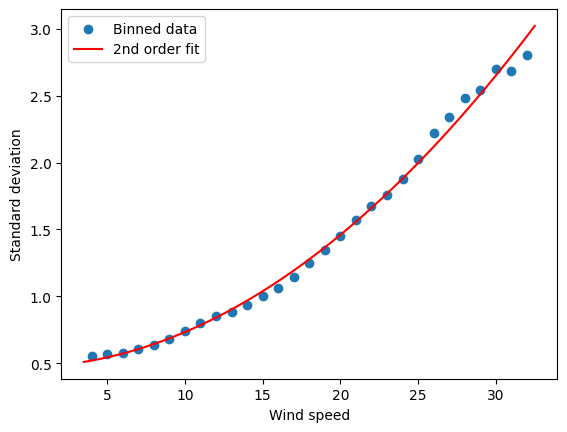

In [138]:
x_plot = np.linspace(WspBinEdges[0], WspBinEdges[-1], 100)
y_plot = MuSigmaFunc(x_plot, pMu)


# plt.bar(Mudatax, Mudatay, width=1, edgecolor='black', label='Binned data')

plt.scatter(Mudatax, Mudatay, label='Binned data')
plt.plot(x_plot, y_plot, label='2nd order fit', zorder=10, color='red')

plt.xlabel('Wind speed')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()

In [139]:
N = 100000
# Random wind speeds based on the weibull distribution
Urand = stats.weibull_min.rvs(WeibullA, scale=Weibullk, size=N)

SigmaUrand = LogNormDist(2, np.random.rand(N), MuSigmaFunc(Urand, pMu), SigmaSigmaFunc(SigmaSigmaRef))

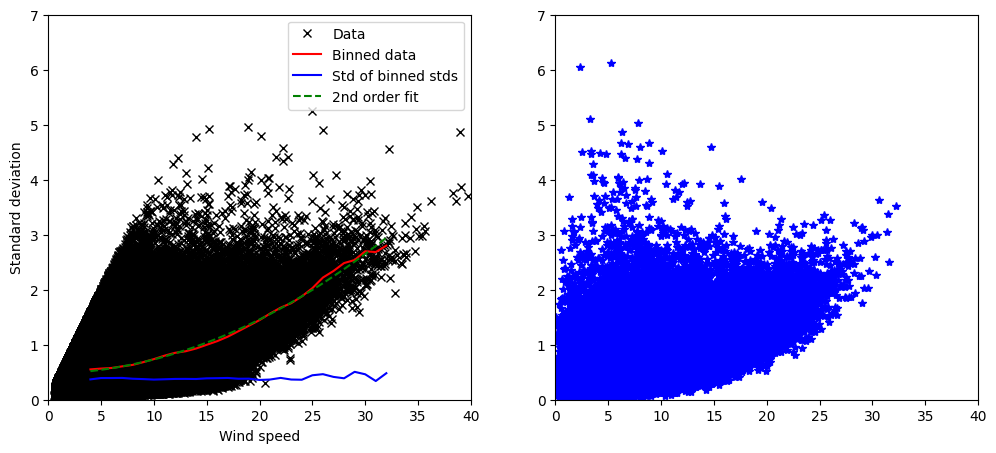

In [140]:
# PLOT TURBULENCE INCLUDING DISTRIBUTION PARAMETERS

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(data1['Wsp'], data1['SigmaU'], 'xk', label='Data')
ax[0].plot(WspBinCenters, MuSigmaBinned, '-r', label='Binned data')
ax[0].plot(WspBinCenters, SigmaSigmaBinned, '-b', label='Std of binned stds')
ax[0].plot(WspBinCenters, MuSigmaFunc(WspBinCenters, pMu), '--g', label='2nd order fit')
ax[0].set_xlim([0, 40])
ax[0].set_ylim([0, 7])
ax[0].set_xlabel('Wind speed')
ax[0].set_ylabel('Standard deviation')
ax[0].legend()
ax[1].plot(Urand, SigmaUrand, '*b')
ax[1].set_xlim([0, 40])
ax[1].set_ylim([0, 7])

plt.show()

### Question 2
Determine the probability distribution of the wind climate uncertainty variable $X_W$ by analysing the
wind data through bootstrapping, further incorporating a 1% uncertainty for windspeed

In [159]:
# Extract the timestamp and wind speed columns to make the bootstrapping process faster
data1_wsp = data1[['Wsp']].copy(deep=True)

# Remove all data before february 2005
data1_wsp = data1_wsp.loc['2005-02-01':]

# Remove data with montly count less than 3000

# Define the maximum valid starting timestamp
# The last possible start date should allow at least one year of data
end_of_data = data1_wsp.index.max()
last_possible_start = end_of_data - pd.DateOffset(years=1)

# Step 3: Filter to get valid indices where a full year of data is available
valid_data = data1_wsp[data1_wsp.index <= last_possible_start]

print(f"End of data: {end_of_data}\nLast possible start: {last_possible_start}")
valid_data

End of data: 2013-08-31 23:50:00
Last possible start: 2012-08-31 23:50:00


,Wsp
Timestamp,
2005-02-01 00:00:00,14.1137
2005-02-01 00:10:00,12.6533
2005-02-01 00:20:00,13.4587
2005-02-01 00:30:00,13.8392
2005-02-01 00:40:00,13.5044
...,...
2012-08-31 23:10:00,10.0874
2012-08-31 23:20:00,8.8803
2012-08-31 23:30:00,9.9503


<Axes: xlabel='Year,Month', ylabel='Mean wind speed'>

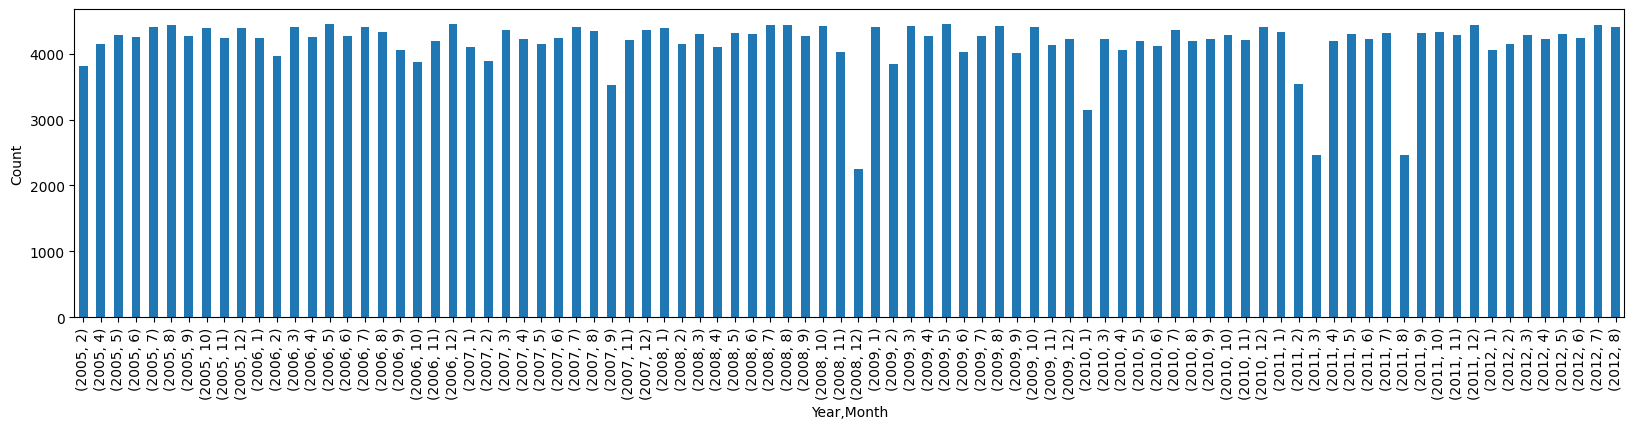

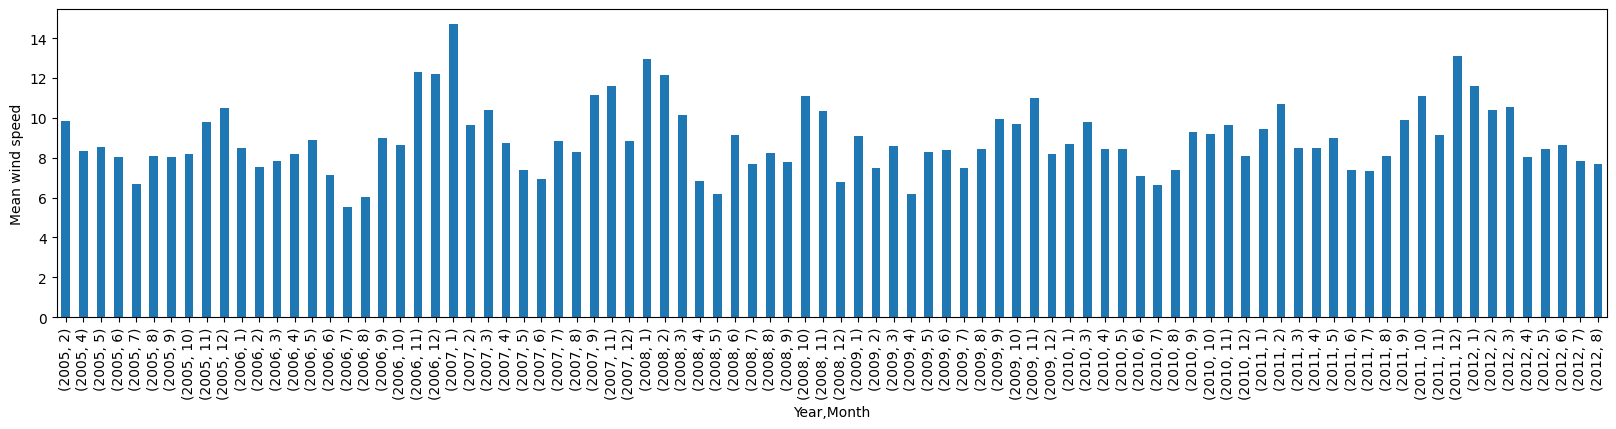

In [175]:
# Count the number of valid data points for each month for each year
valid_data['Year'] = valid_data.index.year
valid_data['Month'] = valid_data.index.month

# Group by year and month and count the number of data points
valid_data.groupby(['Year', 'Month']).count().plot(kind='bar', legend=False, figsize=(20, 4), ylabel='Count')
valid_data.groupby(['Year', 'Month']).mean().plot(kind='bar', legend=False, figsize=(20, 4), ylabel='Mean wind speed')

In [180]:
def get_random_year_mean(df):
    
    # Select a random int from the valid indices
    random_idx = np.random.randint(0, len(df)+1)
    
    # Get the corresponding timestamp
    start_date = df.index[random_idx]
    
    # Define the end date (one year from the start date)
    end_date = start_date + pd.DateOffset(years=1)
    
    # Extract one year of data
    year_data = df[(df.index >= start_date) & (df.index < end_date)]
    
    # Calculate the mean wind speed for the year
    year_mean = year_data['Wsp'].mean()
    
    # print(f"Start date: {start_date}, End date: {end_date}, Mean wind speed: {year_mean}")
    return year_mean

BootstrapMeans = np.array([get_random_year_mean(valid_data) for _ in range(100000)])

# Sort the bootstrap means (only relevant for the confidence interval)
BootstrapMeans = np.sort(BootstrapMeans)

c:\Users\Toke Schäffer\Documents\Egne mapper\DTU\Kandidat\3. semester vind\46500 Probabilistic Methods in Wind Energy\.venv\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\Toke Schäffer\Documents\Egne mapper\DTU\Kandidat\3. semester vind\46500 Probabilistic Methods in Wind Energy\.venv\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


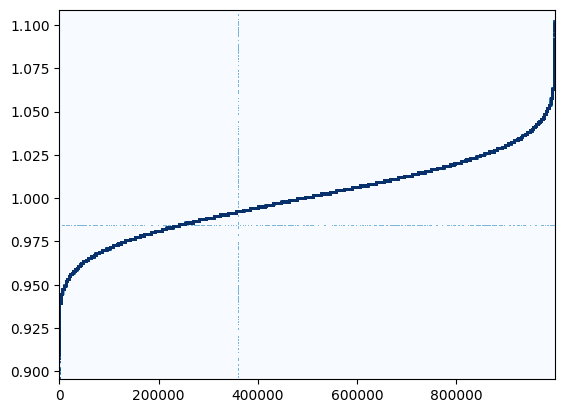

In [225]:
fig = plt.figure()
norm = ImageNormalize(vmin=0., vmax=2, stretch=LogStretch())
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

ax.scatter_density(np.arange(len(BootstrapMeans)), BootstrapMeans, norm=norm, cmap='Blues')

plt.show()

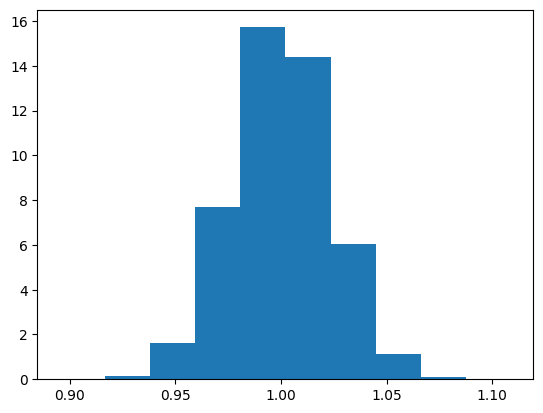

In [226]:
plt.figure()
plt.hist(BootstrapMeans, density=True)
plt.show()

In [227]:
Ubins = np.linspace(BootstrapMeans.min(), BootstrapMeans.max(), 100)

BootstrapHist = np.histogram(BootstrapMeans, bins=Ubins)
BootstrapDist = stats.rv_histogram(BootstrapHist)
pdf_B = BootstrapDist.pdf(Ubins)

Umean = np.mean(BootstrapMeans)
Ustd = np.std(BootstrapMeans)
n = len(BootstrapMeans)

# pdf_N = stats.norm.pdf(Ubins, Umean, Ustd/np.sqrt(n))
pdf_N = stats.norm.pdf(Ubins, Umean, Ustd)

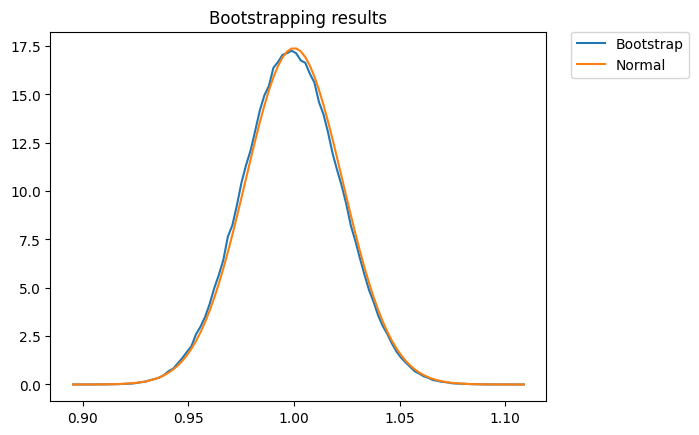

In [228]:
plt.figure()
plt.title('Bootstrapping results')
# plt.hist(BootstrapMeans, bins=Ubins, density=True, alpha=0.5, label='Bootstrap')
plt.plot(Ubins, pdf_B, label='Bootstrap')
plt.plot(Ubins, pdf_N, label='Normal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Question 2 (simple bootstrapping approach)

,Wsp
Timestamp,
2004,10.184009
2005,8.834209
2006,8.479724
2007,9.622015
2008,9.214669
2009,8.562409
2010,8.412106
2011,9.425678
2012,9.194548


<Axes: title={'center': 'Yearly mean wind speed'}, xlabel='Year', ylabel='Wind speed (m/s)'>

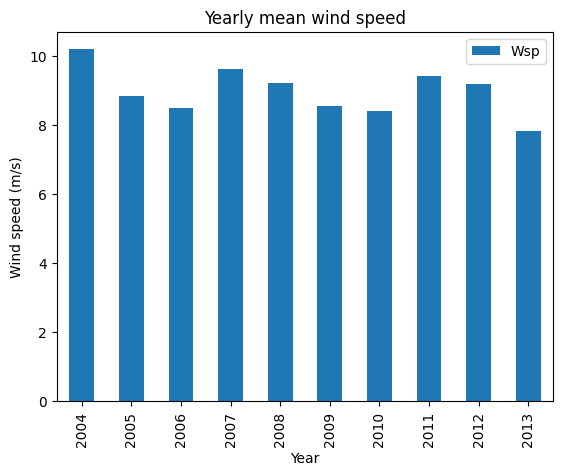

In [186]:
# Wind speed yearly means
wsp_yr_mean_df = pd.DataFrame(data1.groupby(data1.index.year)['Wsp'].mean())
display(wsp_yr_mean_df)

wsp_yr_mean_df.plot(kind='bar', title='Yearly mean wind speed', ylabel='Wind speed (m/s)', xlabel='Year')

In [187]:
wsp_yr_mean_arr = wsp_yr_mean_df.values.flatten()
wsp_yr_mean_arr

array([10.18400904,  8.8342086 ,  8.47972439,  9.62201465,  9.21466908,
        8.56240903,  8.41210571,  9.42567779,  9.19454798,  7.83470162])

In [192]:
Nbootstrap = 1000000
BootstrapSize = len(wsp_yr_mean_arr)

# Rows are the indices of the samples, columns are the bootstrap samples
Bsample = np.random.randint(low=0, high=BootstrapSize, size=(Nbootstrap, BootstrapSize))

BootstrapSample = np.zeros((Nbootstrap, BootstrapSize))
for i in range(Nbootstrap):
    for j in range(BootstrapSize):
        BootstrapSample[i, j] = wsp_yr_mean_arr[Bsample[i, j]]

BootstrapSample = np.mean(BootstrapSample, axis=1)

# Sort the bootstrap means (only relevant for the confidence interval)
BootstrapMeans = np.sort(BootstrapSample)

In [193]:
Ubins = np.linspace(BootstrapMeans.min(), BootstrapMeans.max(), 100)

BootstrapHist = np.histogram(BootstrapMeans, bins=Ubins)
BootstrapDist = stats.rv_histogram(BootstrapHist)
pdf_B = BootstrapDist.pdf(Ubins)

Umean = np.mean(wsp_yr_mean_arr)
Ustd = np.std(wsp_yr_mean_arr)
n = len(wsp_yr_mean_arr)

pdf_N = stats.norm.pdf(Ubins, Umean, Ustd/np.sqrt(n))

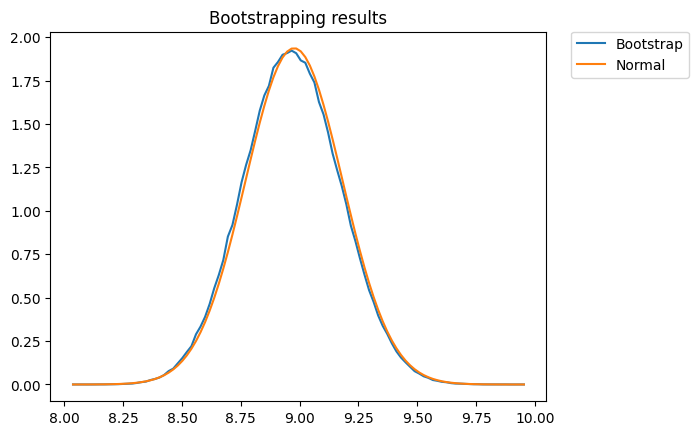

In [194]:
plt.figure()
plt.title('Bootstrapping results')
# plt.hist(BootstrapMeans, bins=Ubins, density=True, alpha=0.5, label='Bootstrap')
plt.plot(Ubins, pdf_B, label='Bootstrap')
plt.plot(Ubins, pdf_N, label='Normal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

We want to normalize the bootstrapping means with their mean to get the uncertainty variable $X_W$ with a mean of 1, that can be used as a multiplier for the Weibull A-parameter.

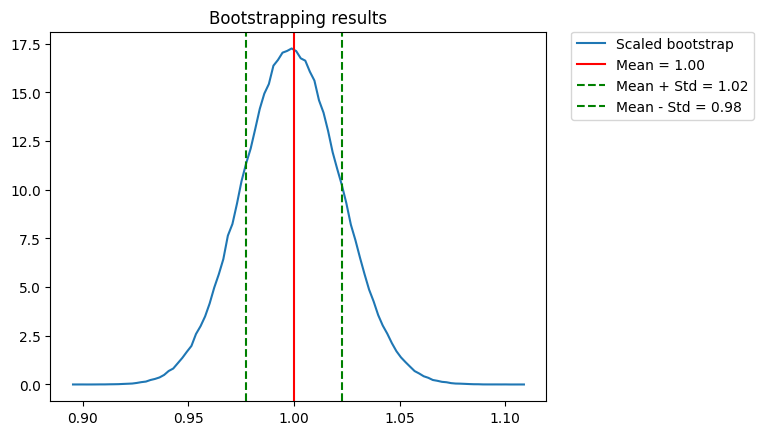

In [219]:
BootstrapMeans = BootstrapMeans / np.mean(BootstrapMeans)

Ubins = np.linspace(BootstrapMeans.min(), BootstrapMeans.max(), 100)

BootstrapHist = np.histogram(BootstrapMeans, bins=Ubins)
BootstrapDist = stats.rv_histogram(BootstrapHist)
pdf_B = BootstrapDist.pdf(Ubins)

mean_climate = np.mean(BootstrapMeans)
std_climate = np.std(BootstrapMeans)


plt.figure()
plt.title('Bootstrapping results')
# plt.hist(BootstrapMeans, bins=Ubins, density=True, alpha=0.5, label='Bootstrap')
plt.plot(Ubins, pdf_B, label='Scaled bootstrap')
plt.axvline(mean_climate, color='red', label=f'Mean = {mean_climate:.2f}')
plt.axvline(mean_climate + std_climate, color='green', linestyle='--', label=f'Mean + Std = {mean_climate+std_climate:.2f}')
plt.axvline(mean_climate - std_climate, color='green', linestyle='--', label=f'Mean - Std = {mean_climate-std_climate:.2f}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

As seen by the x-axis in the plot above, the weibull parameter will be scaled by factors in the range [-5%, 5%] most of the time. We have to now add and additional 1% uncertainty to the wind speed measurements and 1% to the joint distribution fit to the data. We have to use the error propagation formula to calculate the total uncertainty in the wind speed measurements
$\sigma_A+\sigma_B = \sqrt{\sigma_A^2+\sigma_B^2}$  
so in our case $\sigma_{combined} = \sqrt{\sigma_{measure}^2+\sigma_{joint}^2+\sigma_{climate}^2}$

In [220]:
# Calculate the combined uncertainty
sigma_measure = 0.01
sigma_joint = 0.01
sigma_combined = np.sqrt(sigma_measure**2 + sigma_joint**2 + std_climate**2)
print(f"Combined uncertainty: {sigma_combined:.2f}")

Combined uncertainty: 0.03


### Loading the second dataset

In [270]:
InputData = pd.read_excel('../Datasets/ML_ExampleDataSet.xlsx', 'InputVariables')
InputData = InputData.set_index('Sample_No', drop=False)
InputData

,Sample_No,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi
Sample_No,,,,,,,
1,1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000
2,2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217
3,3,6.813467,2.261463,0.129071,88.379710,1.727273,-3.981593
4,4,14.500000,0.704260,0.332996,122.142857,2.090909,0.162810
5,5,5.356299,1.776301,1.147039,160.357143,2.454545,2.639008
...,...,...,...,...,...,...,...
9996,9996,15.991490,2.934493,-0.031461,271.543107,3.760740,14.080259
9997,9997,6.111425,0.948102,0.176589,8.454959,4.124377,41.866315
9998,9998,13.326172,2.043617,0.345013,46.669245,4.488013,-6.197441


In [271]:
TargetData = pd.read_excel('../Datasets/ML_ExampleDataSet.xlsx', 'LoadResults')
TargetData.set_index('PointNo', drop=False, inplace=True)
TargetData

,PointNo,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
PointNo,,,,,,,,,
1,1,747.561872,200.666288,6708.717789,8861.885588,1229.076579,63.457528,4253.317748,15006.726860
2,2,3556.031457,676.339081,16692.647572,6329.099515,6952.985180,1354.995442,10409.290476,16289.414152
3,3,4667.540374,1337.390736,47357.937376,31829.036012,10138.140146,2804.304402,13755.148891,16535.154243
4,4,2468.757942,242.431345,8130.594535,3871.907737,4216.051060,250.684887,12307.312889,16500.098901
5,5,3261.845253,1035.420007,36971.924749,26395.063750,6630.640795,2256.349794,13128.763279,16207.306417
...,...,...,...,...,...,...,...,...,...
9996,9996,6564.464434,858.778565,28091.651088,13608.101268,14513.682848,1147.107370,21518.552601,16773.394758
9997,9997,2047.344061,385.287048,22144.619831,16663.888804,3024.747490,676.705869,3891.227781,15376.750042
9998,9998,5958.074303,646.040924,20715.173212,7395.479028,11789.005321,740.922800,19334.780023,17384.510924


### Question 3
Set up a load surrogate model $M_x$ that maps the 10-minute DELs as function of $u$, $\sigma_{u}$ and $\alpha$

In [272]:
AllInputData = InputData.where(InputData['Sample_No'] == TargetData['PointNo'])
AllInputData.drop(columns='Sample_No', inplace=True)
ANNInputData = AllInputData[['U', 'SigmaU', 'Alpha']]
ANNInputData

,U,SigmaU,Alpha
Sample_No,,,
1,4.000000,0.100000,-0.650000
2,10.150758,1.208656,-0.139692
3,6.813467,2.261463,0.129071
4,14.500000,0.704260,0.332996
5,5.356299,1.776301,1.147039
...,...,...,...
9996,15.991490,2.934493,-0.031461
9997,6.111425,0.948102,0.176589
9998,13.326172,2.043617,0.345013


In [273]:
AllTargetData = TargetData.where(TargetData['PointNo'] == InputData['Sample_No'])
AllTargetData.drop(columns='PointNo', inplace=True)
AllTargetData

,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
PointNo,,,,,,,,
1,747.561872,200.666288,6708.717789,8861.885588,1229.076579,63.457528,4253.317748,15006.726860
2,3556.031457,676.339081,16692.647572,6329.099515,6952.985180,1354.995442,10409.290476,16289.414152
3,4667.540374,1337.390736,47357.937376,31829.036012,10138.140146,2804.304402,13755.148891,16535.154243
4,2468.757942,242.431345,8130.594535,3871.907737,4216.051060,250.684887,12307.312889,16500.098901
5,3261.845253,1035.420007,36971.924749,26395.063750,6630.640795,2256.349794,13128.763279,16207.306417
...,...,...,...,...,...,...,...,...
9996,6564.464434,858.778565,28091.651088,13608.101268,14513.682848,1147.107370,21518.552601,16773.394758
9997,2047.344061,385.287048,22144.619831,16663.888804,3024.747490,676.705869,3891.227781,15376.750042
9998,5958.074303,646.040924,20715.173212,7395.479028,11789.005321,740.922800,19334.780023,17384.510924


In [274]:
nsamples = ANNInputData['U'].count()
print('Number of samples:', nsamples)

Number of samples: 9980


In [275]:
Y1 = AllTargetData['Blade_root_flapwise_M_x']
X = ANNInputData.values

In [276]:
import sklearn.neural_network
Xscaler = sklearn.preprocessing.StandardScaler()
Yscaler = sklearn.preprocessing.StandardScaler()
Xscaler = Xscaler.fit(ANNInputData)
Yscaler = Yscaler.fit(Y1.values.reshape(-1, 1))


train_test_ratio = 0.8
ntrain = int(train_test_ratio * nsamples)

Xtrain = Xscaler.transform(ANNInputData.iloc[0:ntrain, :])
Xtest = Xscaler.transform(ANNInputData.iloc[ntrain:, :])
Ytrain = Yscaler.transform(Y1.values[0:ntrain].reshape(-1, 1))
Ytest = Yscaler.transform(Y1.values[ntrain:].reshape(-1, 1))

In [277]:
ANNmodel = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=1000,
)
ANNmodel.fit(Xtrain, Ytrain)
print('Train set r-square: ' + str(ANNmodel.score(Xtrain, Ytrain)))
print('Test set r-square: ' + str(ANNmodel.score(Xtest, Ytest)))

c:\Users\Toke Schäffer\Documents\Egne mapper\DTU\Kandidat\3. semester vind\46500 Probabilistic Methods in Wind Energy\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train set r-square: 0.96571578041159
Test set r-square: 0.9649741148778401


In [288]:
Xtrain.shape

(7984, 3)

In [278]:
Yout = Yscaler.inverse_transform(ANNmodel.predict(Xtest).reshape(-1, 1))
Yout_test = Yscaler.inverse_transform(ANNmodel.predict(Xtest).reshape(-1, 1))

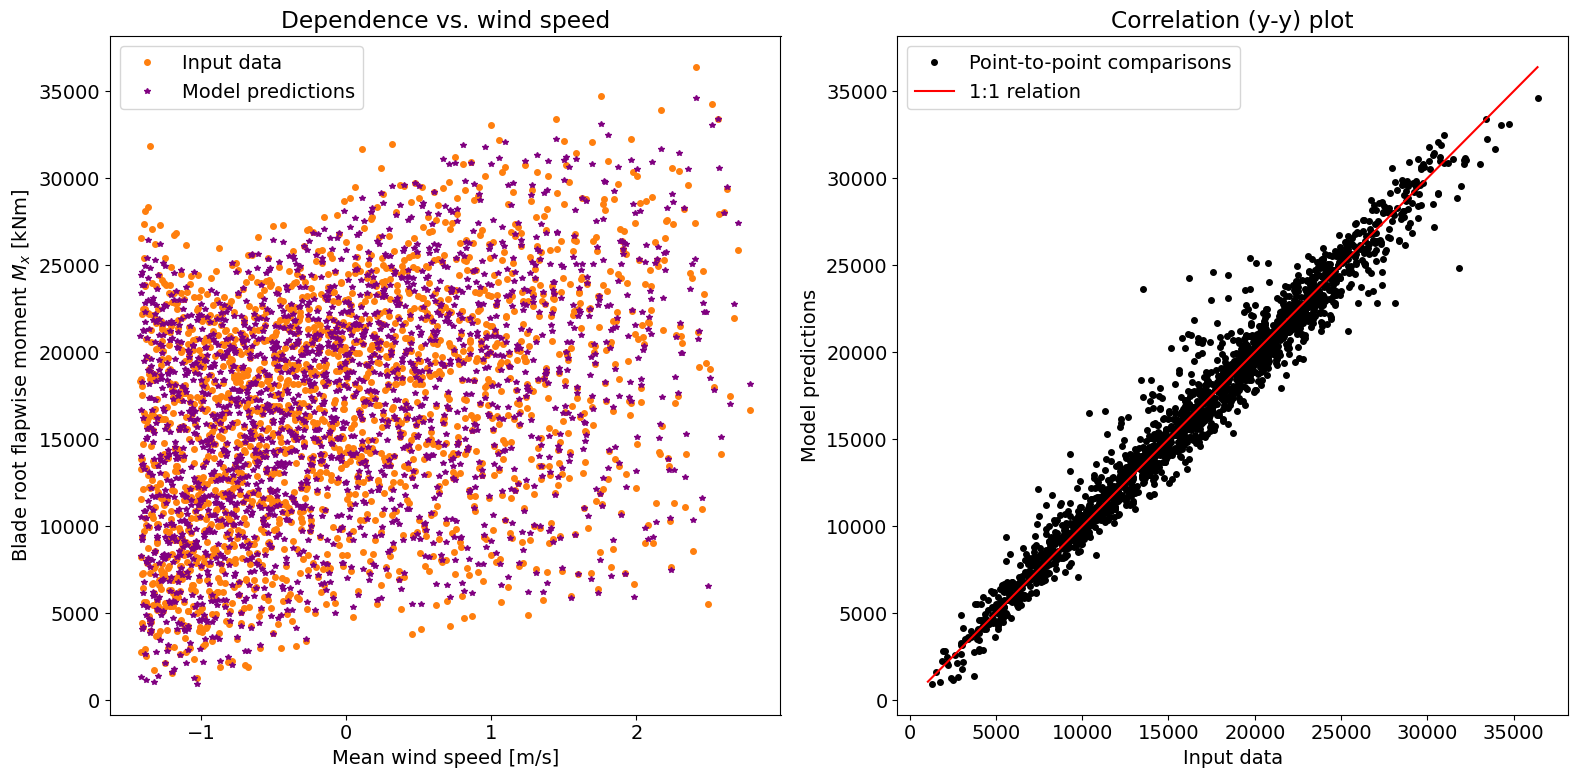

In [279]:
plt.rc('font', size=14)
fig3, axs3 = plt.subplots(1, 2, figsize=(16, 8))

plt.setp(axs3[0],
         title='Dependence vs. wind speed',
         xlabel='Mean wind speed [m/s]',
         ylabel='Blade root flapwise moment $M_x$ [kNm]')

plt.setp(axs3[1],
         title='Correlation (y-y) plot',
         xlabel='Input data',
         ylabel='Model predictions')

axs3[0].plot(Xtest[:, 0],
             Yscaler.inverse_transform(Ytest),
             'o', markersize=4, color='C1')

axs3[0].plot(Xtest[:, 0], Yout_test, '*', markersize=4, color='purple')

axs3[0].legend(['Input data', 'Model predictions'])

axs3[1].plot(Yscaler.inverse_transform(Ytest), Yout_test, 'ok', markersize=4)

axs3[1].plot(np.array([np.min(Y1), np.max(Y1)]),
             np.array([np.min(Y1), np.max(Y1)]), '-r')

axs3[1].legend(['Point-to-point comparisons', '1:1 relation'])
plt.tight_layout()
plt.show()

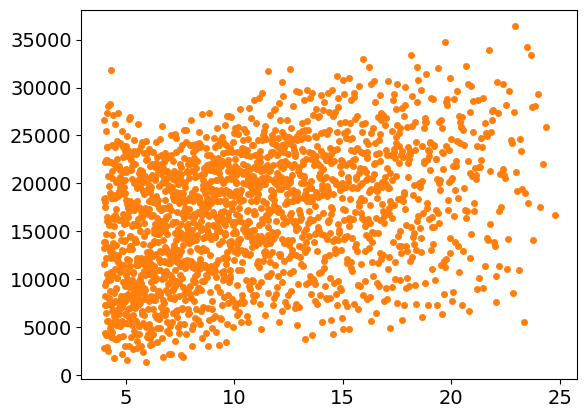

In [280]:
plt.figure()
plt.plot(Xscaler.inverse_transform(Xtest)[:, 0], Yscaler.inverse_transform(Ytest), 'o', markersize=4, color='C1')


In [281]:
Yscaler.inverse_transform(ANNmodel.predict(np.array([[15], [0.05], [0.1]]).T).reshape(-1, 1))

array([[49946.07245541]])

In [282]:
np.array([[10], [10], [10]]).T

array([[10, 10, 10]])

### Question 4
We are now ready to sample the data  
$X_W$ follows a normal distribution with mean = 1 and std = std_combined calculated above  
$\Delta$ follows a lognormal distribution with mean = 1 and std = 0.3  
$X_M$ follows a normal distribution with mean = 1 and std = 0.2
$\alpha$ follows a normal distribution with mean = 0.1 and std = $\min{ \left[1, \frac{1}{u} \right]}$


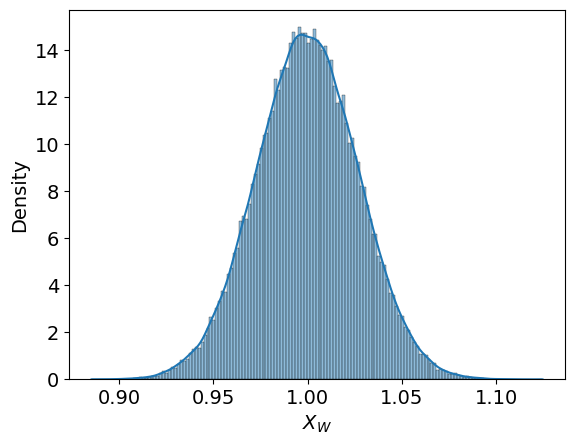

In [313]:
n_sample = 100000
# $X_W$ follows a normal distribution with mean = 1 and std = std_combined calculated above  
X_W_sample = np.random.normal(mean_climate, sigma_combined, n_sample)

plt.figure()
sns.histplot(X_W_sample, kde=True, stat='density')
plt.xlabel(r'$X_W$')
plt.show()

In [307]:
delta_mean, delta_std = 1, 0.3
X_M_mean, X_M_std = 1, 0.2

delta_sample = LogNormDist(2, np.random.rand(n_sample), delta_mean, delta_std)
X_M_sample = stats.norm.rvs(X_M_std, scale=np.exp(X_M_mean), size=n_sample)

# U_sample = stats.weibull_min.rvs(WeibullA, scale=Weibullk, size=n_sample)

# Sample the wind speed while scaling Weibull A with a realization of the combined uncertainty
U_sample = stats.weibull_min.rvs(WeibullA*X_W_sample, scale=Weibullk, size=n_sample)

# $\alpha$ follows a normal distribution with mean = 0.1 and std = $\min{ \left[1, \frac{1}{u} \right]}$
alpha_std = np.minimum(1, 1/U_sample)
alpha_mean = 0.1

alpha_sample = stats.norm.rvs(alpha_mean, scale=alpha_std, size=n_sample)

In [308]:
np.min(U_sample)

np.float64(0.0220192973215953)

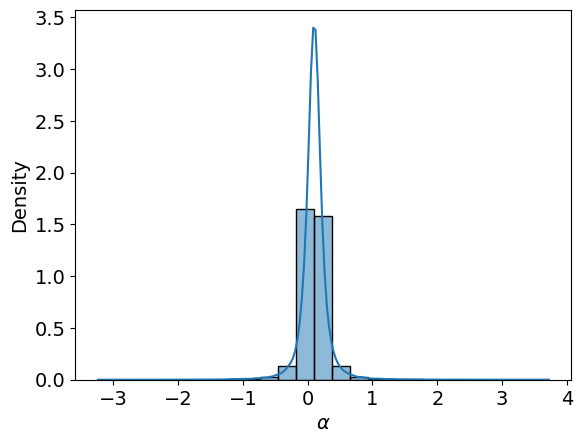

In [309]:
plt.figure()
ax = plt.gca()
sns.histplot(alpha_sample, bins=25, kde=True, stat='density', ax=ax)
ax.set_xlabel(r'$\alpha$')
plt.show()

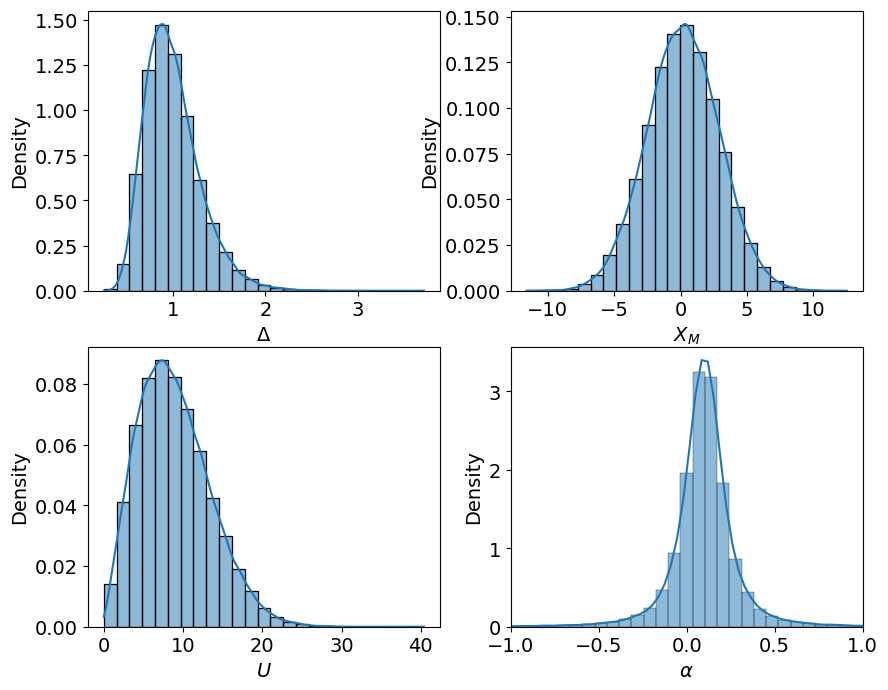

In [310]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
ax_flat = axs.flatten()

sns.histplot(delta_sample, bins=25, kde=True, stat='density', ax=ax_flat[0])
sns.histplot(X_M_sample, bins=25, kde=True, stat='density', ax=ax_flat[1])
sns.histplot(U_sample, bins=25, kde=True, stat='density', ax=ax_flat[2])
sns.histplot(alpha_sample, bins=100, kde=True, stat='density', ax=ax_flat[3])
ax_flat[0].set_xlabel(r'$\Delta$')
ax_flat[1].set_xlabel(r'$X_M$')
ax_flat[2].set_xlabel(r'$U$')
ax_flat[3].set_xlabel(r'$\alpha$')
ax_flat[3].set_xlim([-1, 1])

plt.show()

In [311]:
# Use the ANN model to predict the blade root flapwise moment based on the input data

X_sample = np.array([U_sample, delta_sample, alpha_sample]).T

Y_sample = Yscaler.inverse_transform(ANNmodel.predict(Xscaler.transform(X_sample)).reshape(-1, 1))

c:\Users\Toke Schäffer\Documents\Egne mapper\DTU\Kandidat\3. semester vind\46500 Probabilistic Methods in Wind Energy\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


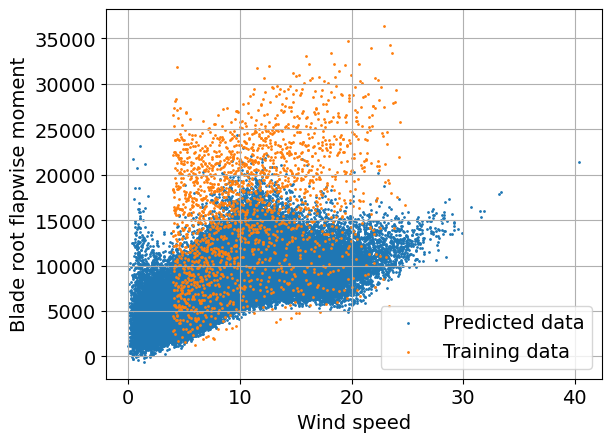

In [312]:
plt.figure()
plt.scatter(U_sample, Y_sample, label='Predicted data', s=1)
plt.scatter(Xscaler.inverse_transform(Xtest)[:, 0], Yscaler.inverse_transform(Ytest), label='Training data', s=1)
plt.xlabel('Wind speed')
plt.ylabel('Blade root flapwise moment')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Fatigue strength normalization factor
k = 4.0 * 10**12

# Fatigue S-N curve slope (Wöhler exponent)
m = 3.0

# Number of short-term estimates in the lifetime sum
# n_short